In [22]:
import SimPEG as simpeg
import simpegMT as simpegmt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Setup the problem

# Frequency
nFreq = 33
freqs = np.logspace(3,-3,nFreq)
# freqs = np.array([100,10,1,0.1,0.01])
# Make the mesh
ct = 10
air = simpeg.Utils.meshTensor([(ct,15,1.3)])
core = np.concatenate( (  np.kron(simpeg.Utils.meshTensor([(ct,15,-1.2)]),np.ones((5,))) , simpeg.Utils.meshTensor([(ct,5)]) ) )
bot = simpeg.Utils.meshTensor([(core[0],10,-1.3)])
x0 = -np.array([np.sum(np.concatenate((core,bot)))])
# Change to use no air
m1d = simpeg.Mesh.TensorMesh([np.concatenate((bot,core,air))], x0=x0)

## Setup model varibles
active = m1d.vectorCCx<0.
layer1 = (m1d.vectorCCx<-200.) & (m1d.vectorCCx>=-600.)
layer2 = (m1d.vectorCCx<-2000.) & (m1d.vectorCCx>=-4000.)
actMap = simpeg.Maps.ActiveCells(m1d, active, np.log(1e-8), nC=m1d.nCx)
mappingExpAct = simpeg.Maps.ExpMap(m1d) * actMap
sig_half = 2e-3
sig_air = 1e-8
sig_layer1 = 1
sig_layer2 = .1
# Make the true model
sigma_true = np.ones(m1d.nCx)*sig_air
sigma_true[active] = sig_half
sigma_true[layer1] = sig_layer1
sigma_true[layer2] = sig_layer2
m_true = np.log(sigma_true[active])
# Make the background model
sigma_0 = np.ones(m1d.nCx)*sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

# Receivers 
# 1D impedance at the surface (elevation 0)
rxList = []
for rxType in ['z1dr','z1di']:
    rxList.append(simpegmt.SurveyMT.RxMT(simpeg.mkvc(np.array([0.0]),2).T,rxType))
# Source list
srcList =[]
for freq in freqs:
        srcList.append(simpegmt.SurveyMT.srcMT_polxy_1Dprimary(rxList,freq,sigma_0))
# Make the survey
survey = simpegmt.SurveyMT.SurveyMT(srcList)
survey.mtrue = m_true
# Set the problem
problem = simpegmt.ProblemMT1D.eForm_psField(m1d,mapping=mappingExpAct)
from pymatsolver import MumpsSolver
problem.solver = MumpsSolver
problem.pair(survey)

In [3]:
# problem.mapping.sigmaMap._transform(m_0)

In [4]:
sig_half

0.002

In [5]:
## Make the observed data 
# Project the data
d_true = survey.dpred(m_true)
survey.dtrue = d_true
# Add noise
std = 0.05 # 5% std
noise = std*abs(survey.dtrue)*np.random.randn(*survey.dtrue.shape)
# Assign the dobs
survey.dobs = survey.dtrue + noise
survey.std = survey.dobs*0 + std
# Assign the data weight
survey.Wd = 1/(abs(survey.dobs)*std)

In [6]:
## Setup the inversion proceedure
C =  simpeg.Utils.Counter()

# Set the optimization
opt = simpeg.Optimization.InexactGaussNewton(maxIter = 50)
opt.counter = C
opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = simpeg.DataMisfit.l2_DataMisfit(survey)
# Regularization
# regMesh = simpeg.Mesh.TensorMesh([m1d.hx[problem.mapping.sigmaMap.maps[-1].indActive]])
# reg = simpeg.Regularization.Tikhonov(regMesh)
reg = simpeg.Regularization.Tikhonov(m1d,mapping=mappingExpAct)
reg.alpha_s = 1e-5
reg.alpha_x = 1.
reg.alpha_xx = .1
# Inversion problem
invProb = simpeg.InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta cooling
beta = simpeg.Directives.BetaSchedule()
betaest = simpeg.Directives.BetaEstimate_ByEig(beta0_ratio=0.75)
saveModel = simpeg.Directives.SaveModelEveryIteration()
# Create an inversion object
inv = simpeg.Inversion.BaseInversion(invProb, directiveList=[beta,betaest])#,saveModel]) 


In [7]:
problem.mapping.sigmaMap.maps[-1]

In [8]:
# Runn the inversion
mopt = inv.run(m_0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.l2_DataMisfit is creating default weightings for Wd.
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.01e+05  1.38e+06  6.91e-07  1.38e+06    2.03e+05      0              
   1  2.01e+05  1.66e+05  6.15e-06  1.66e+05    2.43e+04      0              
   2  2.01e+05  8.65e+04  1.09e-05  8.65e+04    1.51e+04      0   Skip BFGS  
   3  2.51e+04  7.32e+04  1.31e-05  7.32e+04    1.32e+04      0   Skip BFGS  
   4  2.51e+04  3.60e+04  3.07e-05  3.60e+04    7.51e+03      0   Skip BFGS  
   5  2.51e+04  2.97e+04  3.89e-05  2.97e+04    6.45e+03      0   Skip BFGS  
   6  3.14e+03  2.60e+04  4.57e-05  2.60e+04    5

In [9]:
## Setup the inversion proceedure
C =  simpeg.Utils.Counter()

# Set the optimization
optc = simpeg.Optimization.InexactGaussNewton(maxIter = 20)
optc.counter = C
optc.LSshorten = 0.5
optc.remember('xc')
# Data misfit
dmisc = simpeg.DataMisfit.l2_DataMisfit(survey)
# Regularization
# regMesh = simpeg.Mesh.TensorMesh([m1d.hx[problem.mapping.sigmaMap.maps[-1].indActive]])
# reg = simpeg.Regularization.Tikhonov(regMesh)
regc = simpeg.Regularization.Tikhonov(m1d,mapping=mappingExpAct)
regc.alpha_s = 1e-5
regc.alpha_x = 1.
# Inversion problem
invProbc = simpeg.InvProblem.BaseInvProblem(dmisc, regc, optc)
invProbc.counter = C
# Beta cooling
betac = simpeg.Directives.BetaSchedule()
betaestc = simpeg.Directives.BetaEstimate_ByEig(beta0_ratio=0.75)
saveModel = simpeg.Directives.SaveModelEveryIteration()
# Create an inversion object
invc = simpeg.Inversion.BaseInversion(invProbc, directiveList=[betac,betaestc])

In [10]:
mopt2 = invc.run(mopt)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.l2_DataMisfit is creating default weightings for Wd.
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.22e+03  1.75e+01  6.95e-02  1.02e+02    1.27e+02      0              
   1  1.22e+03  2.83e+01  2.63e-02  6.03e+01    6.19e+01      0              
   2  1.22e+03  2.04e+01  2.86e-02  5.52e+01    6.08e+01      0              
   3  1.52e+02  1.84e+01  2.72e-02  2.25e+01    8.98e+00      0              
   4  1.52e+02  1.78e+01  2.46e-02  2.16e+01    3.60e+00      0              
   5  1.52e+02  1.77e+01  2.44e-02  2.14e+01    2.75e+00      0              
   6  1.90e+01  1.77e+01  2.39e-02  1.82e+01    2

In [11]:
moptc=mopt2

In [12]:
## Setup the inversion proceedure
C =  simpeg.Utils.Counter()

# Set the optimization
optc1 = simpeg.Optimization.InexactGaussNewton(maxIter = 20)
optc1.counter = C
optc1.LSshorten = 0.1
optc1.remember('xc')
# Data misfit
dmisc1 = simpeg.DataMisfit.l2_DataMisfit(survey)
# Regularization
# regMesh = simpeg.Mesh.TensorMesh([m1d.hx[problem.mapping.sigmaMap.maps[-1].indActive]])
# reg = simpeg.Regularization.Tikhonov(regMesh)
regc1 = simpeg.Regularization.Tikhonov(m1d,mapping=mappingExpAct)
regc1.alpha_s = 1e-5
regc1.alpha_x = 1.
regc1.mref = reg.mref
# Inversion problem
invProbc1 = simpeg.InvProblem.BaseInvProblem(dmisc1, regc1, optc1)
invProbc1.counter = C
# Beta cooling
betac1 = simpeg.Directives.BetaSchedule()
betaestc1 = simpeg.Directives.BetaEstimate_ByEig(beta0_ratio=0.75)
betaestc1.beta0 = 3.60e-03
saveModel = simpeg.Directives.SaveModelEveryIteration()
# Create an inversion object
invc1 = simpeg.Inversion.BaseInversion(invProbc1, directiveList=[betac1,betaestc1])

In [13]:
moptc1 = invc1.run(mopt2)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.l2_DataMisfit is creating default weightings for Wd.
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.30e-02  1.76e+01  2.85e-02  1.76e+01    1.38e+00      0              
   1  1.30e-02  1.75e+01  2.85e-02  1.75e+01    1.17e+00      1              
   2  1.30e-02  1.75e+01  2.85e-02  1.75e+01    9.35e-01      1   Skip BFGS  
   3  1.62e-03  1.75e+01  2.85e-02  1.75e+01    7.47e-01      1   Skip BFGS  
   4  1.62e-03  1.75e+01  2.85e-02  1.75e+01    1.00e+00      2   Skip BFGS  
   5  1.62e-03  1.75e+01  2.85e-02  1.75e+01    1.00e+00      3   Skip BFGS  
   6  2.03e-04  1.75e+01  2.85e-02  1.75e+01    1.01e+00      3   Skip BFGS  
   7  2.03e-04  1.75e+01 

In [14]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  InexactGaussNewton.doEndIteration       :       50
  InexactGaussNewton.doStartIteration     :       51
  InexactGaussNewton.scaleSearchDirection :       50

Times:                                        mean      sum
  BaseInvProblem.evalFunction             : 3.24e+00, 3.33e+02,  103x
  InexactGaussNewton.findSearchDirection  : 2.07e+01, 1.04e+03,   50x
  InexactGaussNewton.minimize             : 1.37e+03, 1.37e+03,    1x
  InexactGaussNewton.modifySearchDirection: 1.93e+00, 9.63e+01,   50x
  InexactGaussNewton.projection           : 4.69e-05, 9.75e-03,  208x


In [15]:
# import matplotlib.pyplot as plt
# # plt.figure(1)
# # for i in range(problem.G.shape[0]):
# #     plt.plot(problem.G[i,:])
# meshPts = np.concatenate((mesh.gridN[0:1],np.kron(mesh.gridN[1::],np.ones(2))[:-1]))
# modelPts = np.kron(1./model,np.ones(2,))
# axM.semilogx(modelPts,meshPts,color=col)
# plt.figure(2)
# plt.plot(m1d.vectorCCx[active], np.log10(mappingExpAct*survey.mtrue)[active], 'b-')
# plt.plot(m1d.vectorCCx[active], np.log10(mappingExpAct*mopt)[active], 'r-')
# plt.show()


In [16]:
def plotMT1DModelData(problem,models,symList=None):
    # Make the analytic solution
    # 	def makeAnalyticSolution(mesh,model,elev,freqs):
    # 		data1D = []
    # 		for freq in freqs:
    # 			anaEd, anaEu, anaHd, anaHu = simpegmt.Utils.MT1Danalytic.getEHfields(mesh,model,freq,elev)
    # 			anaE = anaEd+anaEu
    # 			anaH = anaHd+anaHu
    # 			# Scale the solution
    # 			# anaE = (anaEtemp/anaEtemp[-1])#.conj()
    # 			# anaH = (anaHtemp/anaEtemp[-1])#.conj()
    # 			anaZ = anaE/anaH
    # 			# Add to the list
    # 			data1D.append((freq,0,0,elev,anaZ[0]))
    # 		dataRec = np.array(data1D,dtype=[('freq',float),('x',float),('y',float),('z',float),('zxx',complex)])
    # 		return dataRec
    def appResPhs(freq,z):
        fr = simpeg.mkvc(freq,2)*np.ones(z.shape)
        app_res = ((1./(8e-7*np.pi**2))/fr)*np.abs(z)**2
        app_phs = np.arctan2(z.imag,z.real)*(180/np.pi)
        return app_res, app_phs
    
    # Setup the figure
    fontSize = 15

    fig = plt.figure(figsize=[9,7])
    axM = fig.add_axes([0.075,.1,.25,.875])
    axM.set_xlabel('Resistivity [Ohm*m]',fontsize=fontSize)
    axM.set_xlim(1e-1,1e5)
    axM.set_ylim(-10000,5000)
    axM.set_ylabel('Depth [km]',fontsize=fontSize)
    axR = fig.add_axes([0.42,.575,.5,.4])
    axR.set_xscale('log')
    axR.set_yscale('log')
    axR.invert_xaxis()
    # axR.set_xlabel('Frequency [Hz]')
    axR.set_ylabel('Apparent resistivity [Ohm m]',fontsize=fontSize)

    axP = fig.add_axes([0.42,.1,.5,.4])
    axP.set_xscale('log')
    axP.invert_xaxis()
    axP.set_ylim(0,90)
    axP.set_xlabel('Frequency [Hz]',fontsize=fontSize)
    axP.set_ylabel('Apparent phase [deg]',fontsize=fontSize)

    # if not symList:
    # 	symList = ['x']*len(models)
    sys.path.append('/home/gudni/Dropbox/code/python/MTview')
    import plotDataTypes as pDt
    # Loop through the models.
    modelList = [problem.survey.mtrue]
    modelList.extend(models)
    if False:
        modelList = [problem.mapping.sigmaMap*mod for mod in modelList]
    for nr, model in enumerate(modelList):
        # Calculate the data
        if nr==0:
            data1D = problem.dataPair(problem.survey,problem.survey.dobs).toRecArray('Complex')
        else:
            data1D = problem.dataPair(problem.survey,problem.survey.dpred(model)).toRecArray('Complex')
        # Plot the data and the model 
        colRat = nr/((len(modelList)-2)*1.)
        if colRat > 1.:
            col = 'k'
        else:
            col = plt.cm.seismic(1-colRat)
        # The model - make the pts to plot
        meshPts = np.concatenate((problem.mesh.gridN[0:1],np.kron(problem.mesh.gridN[1::],np.ones(2))[:-1]))
        modelPts = np.kron(1./(problem.mapping.sigmaMap*model),np.ones(2,))
        axM.semilogx(modelPts,meshPts,color=col)

        ## Data
        # Appres
        pDt.plotIsoStaImpedance(axR,np.array([0,0]),data1D,'zyx','res',pColor=col)
        # Appphs
        pDt.plotIsoStaImpedance(axP,np.array([0,0]),data1D,'zyx','phs',pColor=col)
        try:
            allData = np.concatenate((allData,mkvc(data1D['zyx'],2)),1)
        except:
            allData = simpeg.mkvc(data1D['zyx'],2)
    freq = data1D['freq']
    res, phs = appResPhs(freq,allData)

    stdCol = 'gray'
    axRtw = axR.twinx()
    axRtw.set_ylabel('Std of log10',color=stdCol)
    [(t.set_color(stdCol), t.set_rotation(-45)) for t in axRtw.get_yticklabels()]
    axPtw = axP.twinx()
    axPtw.set_ylabel('Std ',color=stdCol)
    [t.set_color(stdCol) for t in axPtw.get_yticklabels()]
    axRtw.plot(freq, np.std(np.log10(res),1),'--',color=stdCol)
    axPtw.plot(freq, np.std(phs,1),'--',color=stdCol)

    # Fix labels and ticks

    yMtick = [l/1000 for l in axM.get_yticks().tolist()]
    axM.set_yticklabels(yMtick)
    [ l.set_rotation(90) for l in axM.get_yticklabels()]
    [ l.set_rotation(90) for l in axR.get_yticklabels()]
    [(t.set_color(stdCol), t.set_rotation(-45)) for t in axRtw.get_yticklabels()]
    [t.set_color(stdCol) for t in axPtw.get_yticklabels()]
    for ax in [axM,axR,axP]:
        ax.xaxis.set_tick_params(labelsize=fontSize)
        ax.yaxis.set_tick_params(labelsize=fontSize)
    return fig
# plotMT1DModelData(problem,[mopt])

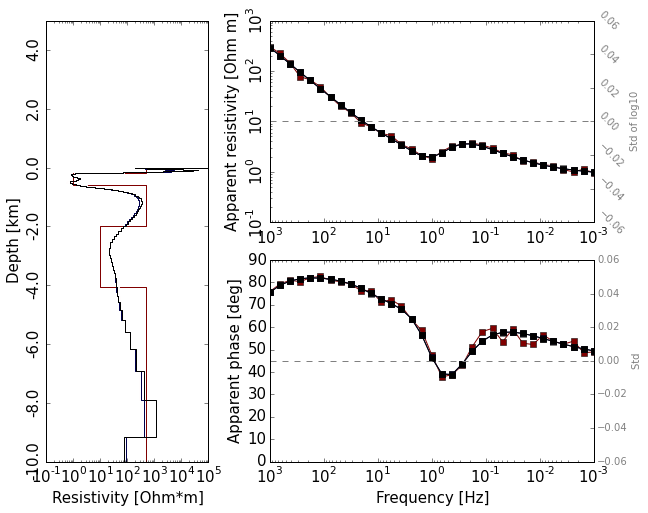

In [23]:
plotMT1DModelData(problem,[mopt,moptc,moptc1])
plt.show()


In [18]:
modelList = [problem.survey.mtrue]
modelList.extend([mopt])
# problem.mapping.sigmaMap*mopt

In [19]:
src = survey.srcList[0]
[[rx.rxType.replace('z1d','zyx')] for rx in src.rxList ]

[['zyxr'], ['zyxi']]

In [20]:
'z1dr'.replace('z1d','zyx')

'zyxr'